In [1]:
from keras.applications.vgg16 import VGG16
model=VGG16()

In [2]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

/var/folders/_6/yv4vw9w5033442shh7vwzfb40000gn/T/ipykernel_14100/2397208556.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [4]:
import os
import cv2
from tqdm import tqdm  # To show progress bar during the image loading process

# Paths to 'yes' and 'no' folders
yes_folder = "Data/Tumor"
no_folder = "Data/Normal"

# Initialize lists to store images and labels
X = []
y = []

# Function to load images from a given folder and label them
def load_images_from_folder(folder, label):
    for img_name in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:  # Check if the image was loaded successfully
            img = cv2.resize(img, (224, 224))
            X.append(img)
            y.append(label)
        else:
            print(f"Warning: Could not load image {img_name}")

# Load images from 'yes' folder (Tumor present)
print("Loading images from 'yes' folder...")
load_images_from_folder(yes_folder, 'Y')

# Load images from 'no' folder (No tumor)
print("Loading images from 'no' folder...")
load_images_from_folder(no_folder, 'N')

# Check the length of images and labels
print(f"Number of images: {len(X)}")
print(f"Number of labels: {len(y)}")

Loading images from 'yes' folder...


 17%|█▋        | 3102/18607 [00:01<00:08, 1925.97it/s]

100%|██████████| 18607/18607 [00:13<00:00, 1390.08it/s]


Loading images from 'no' folder...


100%|██████████| 3066/3066 [00:02<00:00, 1292.10it/s]

Number of images: 21672
Number of labels: 21672


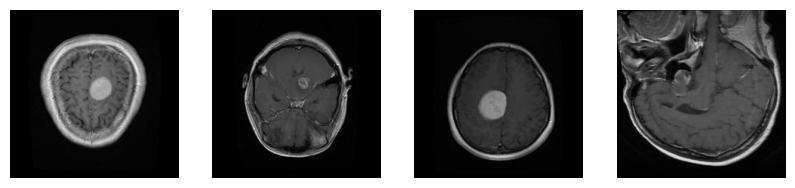

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [7]:
#preprocessing steps
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [8]:
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (14520, 224, 224, 3)
X_test Shape:  (7152, 224, 224, 3)
y_train Shape:  (14520, 2)
y_test Shape:  (7152, 2)


In [9]:
from keras.applications import vgg16


img_rows, img_cols = 224, 224


vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False

# Let's print our layers
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [10]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 2

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [13]:
history = model.fit(X_train,y_train,
                    epochs=5,
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/5
454/454 [==============================] - 2668s 6s/step - loss: 0.1794 - accuracy: 0.9486 - val_loss: 0.0788 - val_accuracy: 0.9704
Epoch 2/5
454/454 [==============================] - 4207s 9s/step - loss: 0.0638 - accuracy: 0.9780 - val_loss: 0.0631 - val_accuracy: 0.9792
Epoch 3/5
454/454 [==============================] - 6305s 14s/step - loss: 0.0479 - accuracy: 0.9831 - val_loss: 0.0456 - val_accuracy: 0.9873
Epoch 4/5
454/454 [==============================] - 4702s 10s/step - loss: 0.0325 - accuracy: 0.9906 - val_loss: 0.0584 - val_accuracy: 0.9869
Epoch 5/5
454/454 [==============================] - 2459s 5s/step - loss: 0.0270 - accuracy: 0.9903 - val_loss: 0.0494 - val_accuracy: 0.9866


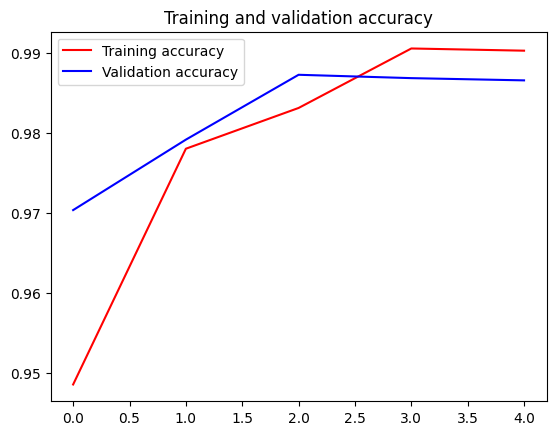

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

224/224 [==============================] - 742s 3s/step


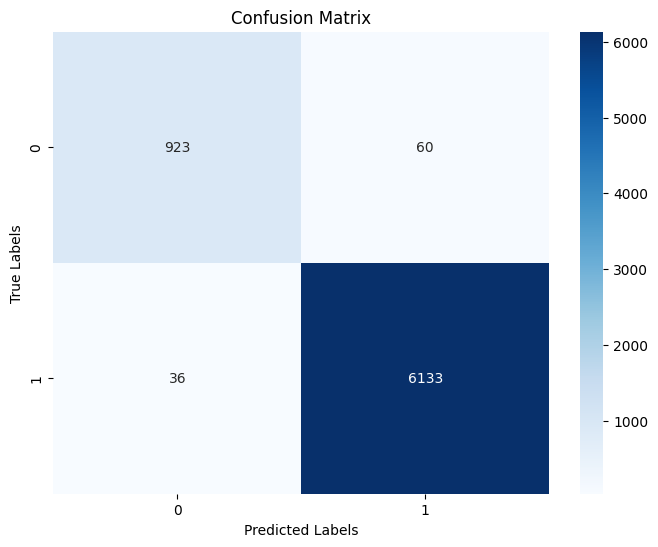

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# Precision
precision = precision_score(y_true, y_pred_classes)

# Recall
recall = recall_score(y_true, y_pred_classes)

# F1 Score
f1 = f1_score(y_true, y_pred_classes)

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Classification report
report = classification_report(y_true, y_pred_classes, target_names=['No Tumor', 'Tumor'])
print(report)


Accuracy: 0.9866
Precision: 0.9903
Recall: 0.9942
F1 Score: 0.9922
              precision    recall  f1-score   support

    No Tumor       0.96      0.94      0.95       983
       Tumor       0.99      0.99      0.99      6169

    accuracy                           0.99      7152
   macro avg       0.98      0.97      0.97      7152
weighted avg       0.99      0.99      0.99      7152

